### Neoantigen_Histograms

This notebook produces 2D histograms for binding activity versus RNA transcript count

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
from multiprocessing import Pool

%matplotlib inline

In [111]:
import matplotlib
from pylab import figure, cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

font = {'size'   : 16}
matplotlib.rc('font', **font)

def xid_to_geneid(k):
    k = ':'.join(k.split('_'))
    v = ID_dict[k]
    return v.split('|')[0].split(':')[1]

def xid_to_tpm(v):
    try:
        geneid = xid_to_geneid(v)
        return tpm_dict[geneid]
    except:
        return 0
    
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'$10^{{{}}}$'.format(b)

def get_num(a,b):
    return a-b+a

def get_heatmap(plot_df, edge_idx=2):
    yedges = [0, 2, 20, 80, 120, 380, 620, 1380, 2000, 4000, 6000, 10000]
    
    if edge_idx == 1:
        xedges = [2, 18, 80, 120, 380, 620, 1000, 10000, 20000, 30000, 40000, 50000]
    else:
        xedges =  [0, 20, 40,  60,  80,  100,  140, 160, 200,   300,   400,   500]
        xedges =   [0, 20, 40,  60,  80,  100,   200,   300,   400,   500]
    H, xedges, yedges = np.histogram2d(plot_df[1].values, plot_df['tpm'].values, bins=(xedges, yedges))      
    return H, xedges, yedges
    
def plot_heatmap(H, xedges, yedges, vmin=1e2, vmax=1e8, cmap='inferno', allele=None, inset=False, box=False):
    f = figure(figsize=(10,10))

    xticks = np.convolve(xedges, np.ones(2)/2, mode='valid').astype('int')
    yticks = np.convolve(yedges, np.ones(2)/2, mode='valid').astype('int')
    print(xticks)
    ax = f.add_axes([0.17, 0.02, 0.72, 0.79])
    axcolor = f.add_axes([0.90, 0.02, 0.03, 0.79])
    #ax=plt.gca()

    ax.set_xlabel('RNA (tpm)')
    ax.set_xticks(range(len(yticks)))
    ax.set_yticks(range(len(xticks)))
    ax.set_yticklabels(xticks)
    ax.set_xticklabels(yticks)
    ax.set_ylabel('Binding affinity (nM)')
    ax.xaxis.set_ticks_position('bottom')

    im = ax.matshow(H, norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    if inset:
        plt.setp(ax.spines.values(), linewidth=7)
        
    if box: 
        # Create a Rectangle patch
        rect = patches.Rectangle((-0.45, -0.45), 10.85, 4, linewidth=7, edgecolor='black', 
                                 facecolor="None")

        # Add the patch to the Axes
        ax.add_patch(rect)
    #f.colorbar(im, cax=axcolor,  format='$%.0e$')
    f.colorbar(im, cax=axcolor,  format=ticker.FuncFormatter(fmt), label='Number of peptides')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_title(allele)
    f.show()
    
    return H

In [5]:
import pickle

ID_dict = np.load('../data/ID_dict.npy', allow_pickle=True)
ID_dict = ID_dict.item()

# Link gene names to tpm
# RNA seq data
RNAseq = pd.read_csv('../data/fpkm_tpm.csv')

# tpm values
tpm_dict = RNAseq.set_index('geneID').to_dict()['TA1_wt1']

### Read in processed data per allele

In [12]:
alleles = ['HLA-A03_01', 'HLA-B07_02', 'HLA-B35_03','HLA-C04_01', 'HLA-C07_02']
allele = alleles[0]
files = glob.glob('../data/results/'+allele+'/*')

In [13]:
plot_df = pd.read_pickle('../data/BAs_flat_'+allele+'.pkl')

### Transcript data

In [16]:
# Set up plotting df

plot_df = plot_df.rename(columns = {0:'ID'})
plot_df['tpm'] = plot_df['ID'].apply(xid_to_tpm)
plot_df = plot_df.fillna(0)

In [15]:
arr =   [0, 20, 40,  60,  80,  100,   200,   300,   400,   500]

ticks = [int((arr[it] + arr[it+1])/2) for it, _ in enumerate(arr[:-1])]
ticks

[10, 30, 50, 70, 90, 150, 250, 350, 450]

### Specific allele

[   10    49   100   250   500   810  5500 15000 25000 35000 45000]
[   10    49   100   250   500   810  5500 15000 25000 35000 45000]
[   10    49   100   250   500   810  5500 15000 25000 35000 45000]
[   10    49   100   250   500   810  5500 15000 25000 35000 45000]
[   10    49   100   250   500   810  5500 15000 25000 35000 45000]


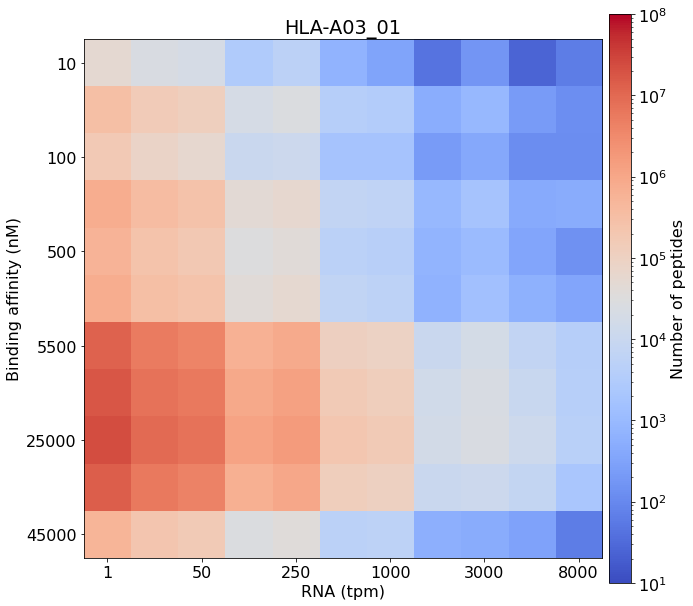

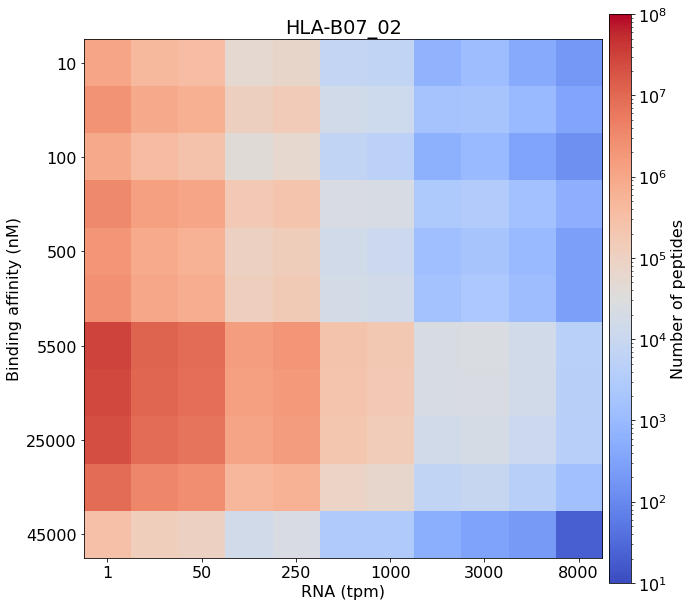

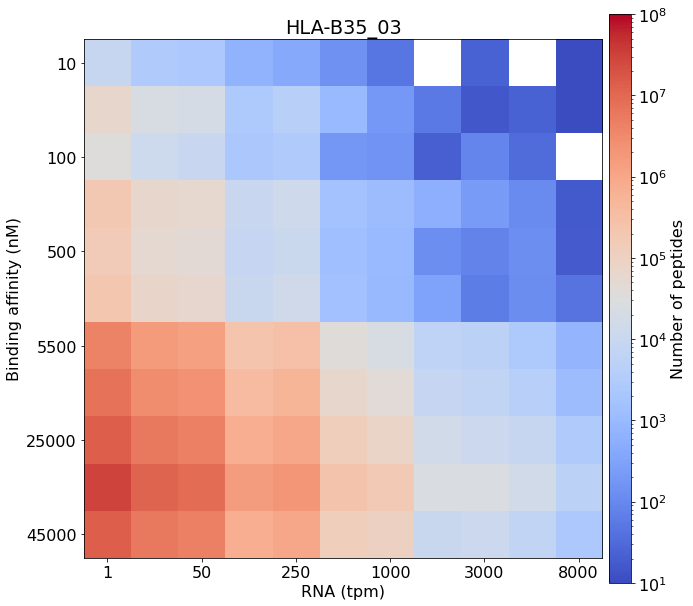

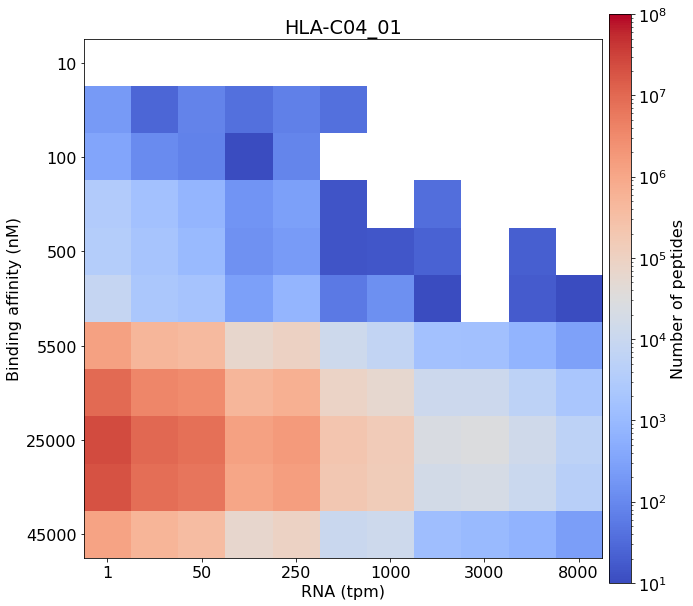

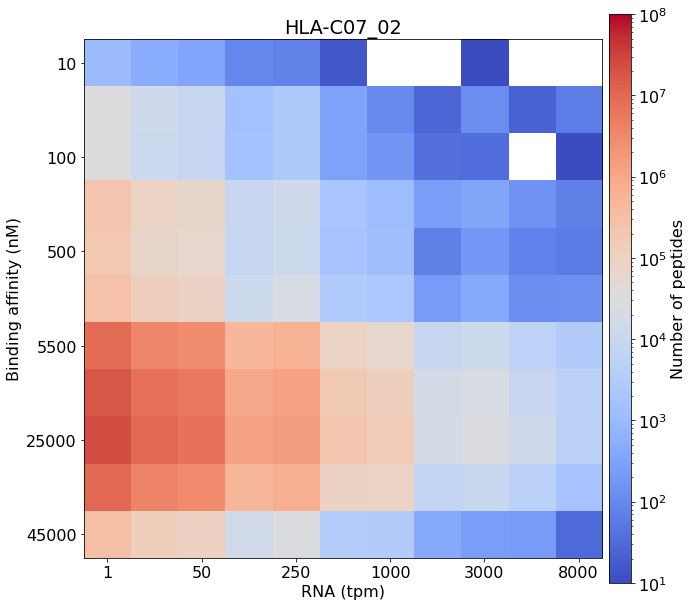

In [26]:
# Figures 7
for num, allele in enumerate(alleles):
    H = np.load('../data/H_'+allele+'.npy')

    xedges = [2, 18, 80, 120, 380, 620, 1000, 10000, 20000, 30000, 40000, 50000]
    H = plot_heatmap(H, xedges, yedges, 
                     vmin=1e1, vmax=1e8,
                     cmap='coolwarm', allele=allele)

    plt.savefig('fig7_'+str(num)+'.svg',dpi=300, bbox_inches = "tight")

### Create combined plot

In [71]:
import matplotlib.patches as patches

In [72]:
alleles = ['HLA-A03_01', 'HLA-B07_02', 'HLA-B35_03','HLA-C04_01', 'HLA-C07_02']

Hs = []
for allele in alleles:
    Hs.append(np.load('../data/H_'+allele+'.npy'))

[   10    49   100   250   500   810  5500 15000 25000 35000 45000]


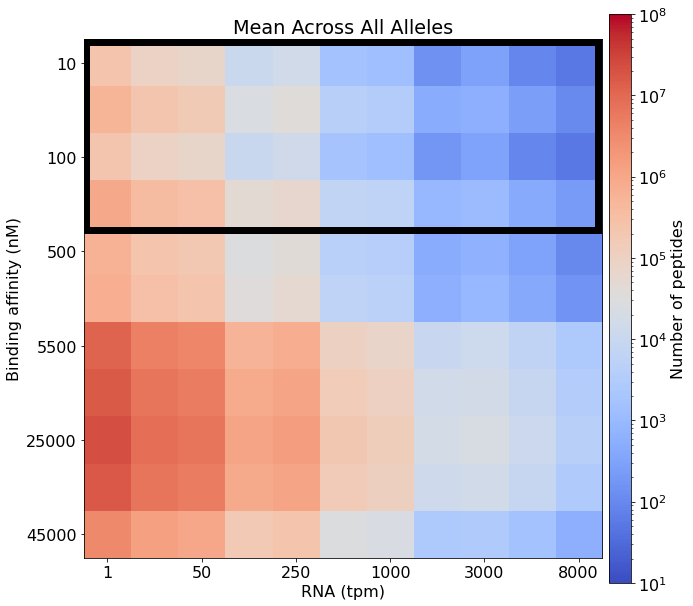

In [113]:
# figure 6
mean_H = np.mean(np.array(Hs),0)

xedges = [2, 18, 80, 120, 380, 620, 1000, 10000, 20000, 30000, 40000, 50000]
#yedges = [0, 2, 20, 80, 120, 380, 620, 1380, 2000, 4000, 6000, 10000]

allele = 'Mean Across All Alleles'
#
H = plot_heatmap(mean_H, xedges, yedges, 
                 vmin=1e1, vmax=1e8,
                 cmap='coolwarm', allele=allele, box=True)

plt.savefig('fig6.svg',dpi=300, bbox_inches = "tight")

## Create mean inset plot

[ 10  30  50  70  90 150 250 350 450]


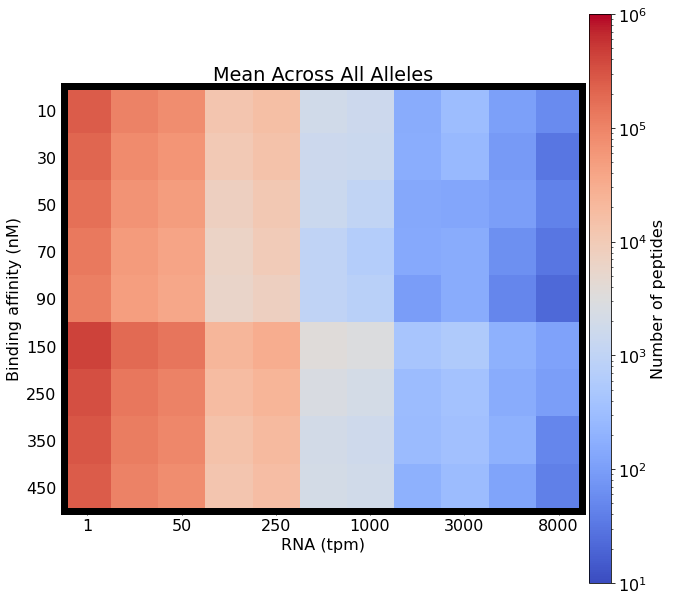

In [118]:
# figure 6 inset

Hs = []
for allele in alleles:
    Hs.append(np.load('../data/H_small_'+allele+'.npy'))
    
H, xedges, yedges = get_heatmap(plot_df, edge_idx=2)

mean_H = np.mean(np.array(Hs),0)

allele = 'Mean Across All Alleles'
H = plot_heatmap(mean_H, xedges, yedges, 
                 vmin=1e1, vmax=1e6,
                 cmap='coolwarm', allele=allele, inset=True)

plt.savefig('fig6_inset.svg',dpi=300, bbox_inches = "tight")